---
# Model S - Data Augmentation and L2 Regularization with RMSprop Optimizer
- **128 x 128 x 3** Image size.
- **Custom Data Augmentation Pipeline**
    - Random **Horizontal** Flip
    - Random Rotation **5%**
    - Random Zoom **5%**
    - Random Contrast **5%**
    - Random Brightness **5%**
- **VGG16 Convolutional Base** with **Imagenet Weights**, **128 x 128 x 3 Input size**.
- **4 x 4 x 128** Tensor before the **Flatten** layer.
- **Classifier** with:
- **64** Batch size.
- Adaptive Moment Estimation **(Adam)** optimizer.
- **0.001** Initial Learning rate.
- **Sparse Categorical Cross-Entropy** loss function.
- **Reduce Learning Rate on Plateau** callback with a **0.1** factor and **3** patience.
- **Early Stopping** callback with **6** patience.
- **Model Checkpoint** callback to save the best model based on validation loss.
- **256** Dense layer with **ReLU** activation.
- **10** Dense output layer with **Softmax** activation.
- **Dropout** layers with **0.5** rate after the Flatten and Dense layers.
- **L2** regularization with **0.0001** rate on the Dense layers.
- **815 914** Total Parameters.
- **30** Epochs.

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from PIL import Image

TensorFlow version: 2.12.0


---
#### Group Datasets

In [3]:
IMG_SIZE = 128

train_dirs = [f'../data/train1_resized_{IMG_SIZE}', f'../data/train3_resized_{IMG_SIZE}', f'../data/train4_resized_{IMG_SIZE}', f'../data/train5_resized_{IMG_SIZE}']
validation_dir = f'../data/train2_resized_{IMG_SIZE}'
test_dir = f'../data/test_resized_{IMG_SIZE}'

- ((2221985 + 2221986) % 5) + 1 = 2  
- **Validation set: train2**.  

---
#### Create Datasets

In [5]:
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


- We define the image size of 32 x 32 x 3, batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Loading the VGG16 Model

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

- We load the VGG16 model with the imagenet weights, without the top layer and with the input shape of 128 x 128 pixels and 3 channels.

---
#### Custom Data Augmentation Pipeline

In [ ]:
data_augmentation = keras.Sequential(
    [
        # keras.layers.RandomCrop(height=16, width=16), # This layer is commented out because it is not compatible with the current model architecture.
        keras.layers.RandomFlip("horizontal"),
        # keras.layers.RandomTranslation(0.1, 0.1), # This layer is commented out because it didn't improve the model performance.
        keras.layers.RandomRotation(0.05),
        keras.layers.RandomZoom(0.05),
        keras.layers.RandomContrast(0.05),
        keras.layers.RandomBrightness(0.05),
    ]
)

---
#### Feature Extraction

In [9]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        images = data_augmentation(images)
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)

1/1 [==============================] - 0s 63ms/step


- We extract the features from the convolutional base of the VGG16 model for the train and validation dataset.
- We don't need to extract the features from the test dataset because we will use the full model to predict it.

---
### Saving the features and labels

In [10]:
np.save('../features/05_model_t_feat_ext_data_augm_adam_train_features.npy', train_features)
np.save('../features/05_model_t_feat_ext_data_augm_adam_labels.npy', train_labels)
np.save('../features/05_model_t_feat_ext_data_augm_adam_val_features.npy', val_features)
np.save('../features/05_model_t_feat_ext_data_augm_adam_val_labels.npy', val_labels)

---
### Loading the features and labels

In [11]:
train_features = np.load('../features/05_model_t_feat_ext_data_augm_adam_train_features.npy')
train_labels = np.load('../features/05_model_t_feat_ext_data_augm_adam_train_labels.npy')
val_features = np.load('../features/05_model_t_feat_ext_data_augm_adam_val_features.npy')
val_labels = np.load('../features/05_model_t_feat_ext_data_augm_adam_val_labels.npy')

---
#### Classifier Arquitecture

In [12]:
inputs = keras.Input(shape=(4, 4, 512))
x = data_augmentation(inputs)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L2(1e-4))(x)
classifier = models.Model(inputs=inputs, outputs=outputs)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 2, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,054,218
Trainable params: 1,054,218
Non-train

---
#### Classifier Compilation

In [13]:
initial_learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/05_model_s_feat_ext_data_augm_adam.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

classifier.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

---
#### Classifier Training

In [14]:
history = classifier.fit(train_features,
                    train_labels,
                    epochs=30,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/40
1245/1250 [============================>.] - ETA: 0s - loss: 13.0404 - accuracy: 0.4777
Epoch 1: val_loss improved from inf to 5.61746, saving model to ../models/03_model_t_feat_ext_adagrad_classifier.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 13.0239 - accuracy: 0.4779 - val_loss: 5.6175 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 2/40
1239/1250 [============================>.] - ETA: 0s - loss: 9.2055 - accuracy: 0.5607
Epoch 2: val_loss improved from 5.61746 to 5.05848, saving model to ../models/03_model_t_feat_ext_adagrad_classifier.h5
1250/1250 [==============================] - 6s 5ms/step - loss: 9.2047 - accuracy: 0.5606 - val_loss: 5.0585 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 3/40
1250/1250 [==============================] - ETA: 0s - loss: 8.1212 - accuracy: 0.5811
Epoch 3: val_loss improved from 5.05848 to 4.74766, saving model to ../models/03_model_t_feat_ext_adagrad_classifier.h5
1250/1250 [==============================] - 6s 5ms/step

---
#### Save Model History

In [15]:
with open("../history/05_model_t_feat_ext_data_augm_adam.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Classifier Evaluation

In [16]:
val_loss, val_acc = classifier.evaluate(val_features, val_labels)
print(f'Classifier Validation Loss: {val_loss:.2f}')
print(f'Classifier Validation Accuracy: {val_acc:.2%}')

313/313 [==============================] - 0s 1ms/step - loss: 4.1897 - accuracy: 0.7031
Classifier Validation Loss: 4.19
Classifier Validation Accuracy: 70.31%


---
#### Model Training Visualization

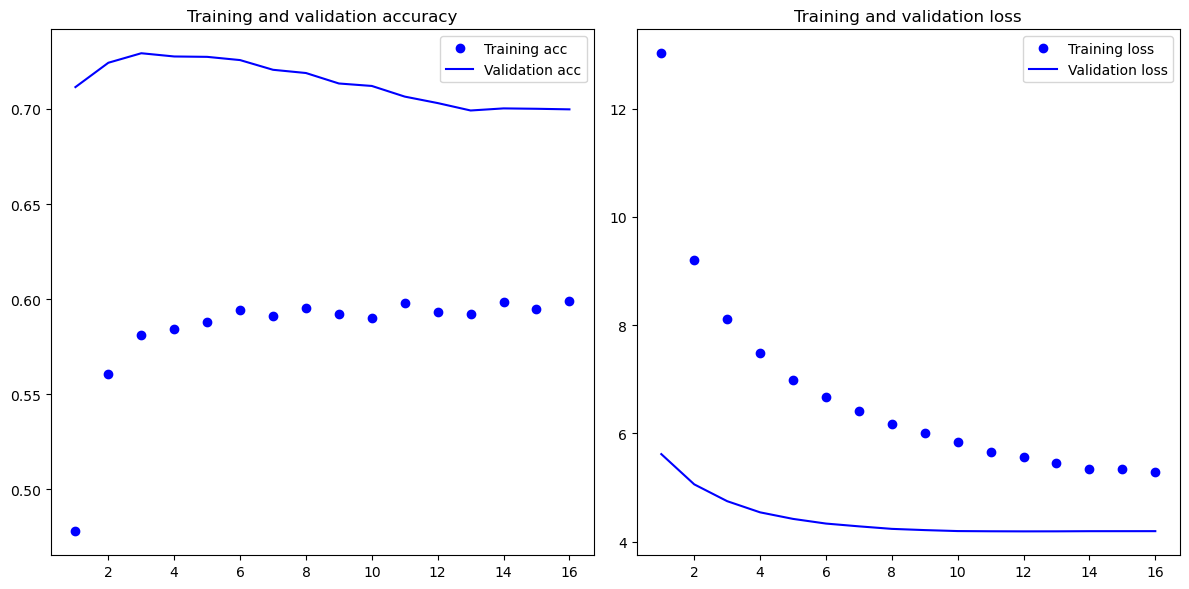

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation accuracy and loss over the epochs:
    - We see that the model begins slightly overfitting after the **15th** epoch. The validation accuracy stops improving significantly while the training accuracy keeps improving.  
    - The validation loss stops improving significantly after the **15th** epoch while the training loss keeps improving. 
    - The best model, based on validation loss, is saved on the **20th** epoch.   

---
#### Building the full model (VGG16 + Classifier)

In [18]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = classifier(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"])

model.save('../models/05_model_t_feat_ext_data_augm_adam_model.h5')

- We join the VGG16 convolutional base with our classifier trained with the extracted features, compile it, and save it.

---
#### Model Testing

In [19]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 134ms/step


---
#### Confusion Matrix

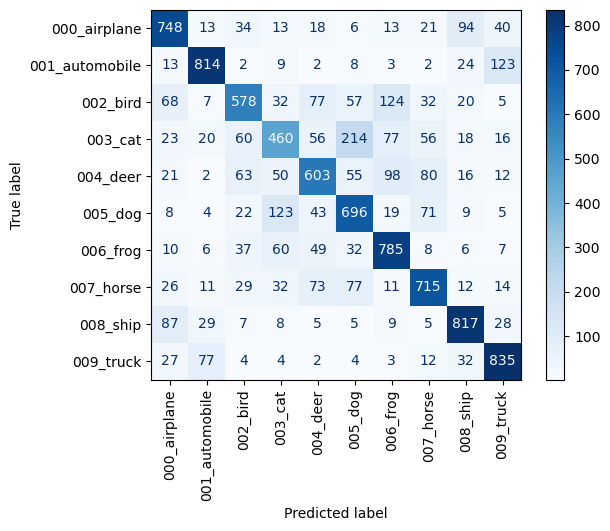

In [20]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model still has a hard time distinguishing between the categories 003_cat and 005_dog but with less error.  
    - The model has a below average performance on the categories 003_cat, 005_dog and 002_bird, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the error is not as significant.  
    - The model has an above average performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.
    - The model has shown a performance increase with higher accuracy across all categories.

---
#### ROC Curve Analysis

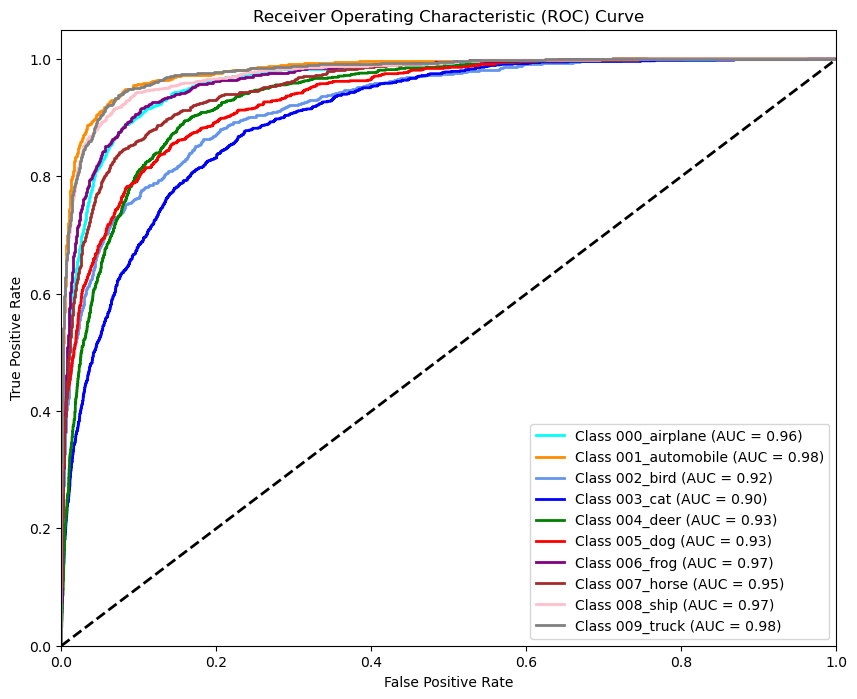

In [21]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a good performance on the ROC curve for most categories.  
    - The categories 003_cat, 002_bird and 005_dog have the worst AUC (Area Under Curve) performance.
    - The other categories have the same performance but with higher AUC.
    - The category 001_automobile, 008_ship and 009_truck has the best AUC performance.
    - The overall AUC performance increases as the false positive rate decreases and the true positive rate increases.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.  

In [22]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 70.51%
Precision - Macro: 70.3%
Recall - Macro: 70.51%
F1-score - Macro: 70.19%
Precision - Weighted: 70.3%
Recall - Weighted: 70.51%
F1-score - Weighted: 70.19%


- **Since the dataset is balanced, the **MACRO** average is a good metric to evaluate the model.**

# Conclusion
- We resized our images to be the 128 x 128.
- We extracted feature maps from our datasets using the convolutional base of the VGG16.
- We have trained a classifier with those extracted features.  
- We experimented with various classifier architectures, and we settled for this one, keeping input size to 128 x 128 and our classifier with a 512 dense layer.  
     - Different learning rates were tested; we settled for the Reduce Learning Rate on Plateau callback with a starting value of 0.001.
    - Various batch sizes were explored; this size was optimal for this architecture.  
    - Multiple optimizers were evaluated; we settled for RMSProp.
    - Several regularization values were tried; these values worked best.
    - Different dropout rates were assessed; this rate provided the best results.
    - Various epoch counts were tested; 30 epochs were optimal.
    - We used L1 and L2 regularization on the classifier.
    - Dropout was applied to the input layer and the dense layer.
- The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
- Overfitting was observed after **15 epochs**, but the best model was saved at the **20th epoch**.
- We evaluated the model using a confusion matrix to analyze its performance on each category.
- We evaluated the model using ROC curves for a deeper performance analysis.
- **The model achieved an accuracy of 81.83% on the test set**.
- Performance on the test set was good, with:
    - Macro F1-score: 89.29%
    - Weighted F1-score: 89.29%
    - Macro precision: 89.32%
    - Weighted precision: 89.32%
    - Macro recall: 89.29%
    - Weighted recall: 89.29%

### Future Work
- In the next phase, we will:
    - Implement and test transfer learning with the VGG16 convolutional base and our classifier along with fine-tuning by later unfreezing some of the VGG16 layers to further improve model generalization.
    - Experiment with data augmentation to improve model generalization.
    - Explore additional regularization methods to address overfitting.